<!--NOTEBOOK_HEADER-->
*This notebook contains course material from [CBE40455](https://jckantor.github.io/CBE40455) by
Jeffrey Kantor (jeff at nd.edu); the content is available [on Github](https://github.com/jckantor/CBE40455.git).
The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<!--NAVIGATION-->
< [Queuing Systems](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/02.02-Queuing-Systems.ipynb) | [Contents](toc.ipynb) | [Model Development in SimPy](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/02.04-Discrete-Event-Simulation-of-a-Batch-Process.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455/blob/master/notebooks/02.03-Emergency_Room_Simulation.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE40455/master/notebooks/02.03-Emergency_Room_Simulation.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# Emergency Room Simulation

This notebook is the result of an in-class exercise in the simulation and analysis of a simple queuing model for a hospital emergency room.

## Initializations

Install the Simpy library and import necessary libraries.

In [7]:
!pip install simpy

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt    # for plotting
import numpy as np                 # for numerical calculations
import pandas as pd                # for analysis of simulation data
import random                      # for generating pseudo-random numbers
import simpy                       # for discrete event simulation

## Poisson processes

We assume $n$, the average number of patients arriving in a period of $\tau$ minutes, is given by $\lambda \tau$ where $\lambda$ represents the average rate of arrival in units of patients per minute. If the events are statistically independent and identically distributed in time,  this probability is uniformly distributed in time, then this is known as a [Poisson Process](https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-262-discrete-stochastic-processes-spring-2011/course-notes/MIT6_262S11_chap02.pdf).

One of the key properties of a Poisson process is that the period of time between arrival events, $t$, is a random number distributed according to the exponential distribution

$$p(t|\lambda) = \lambda e^{-\lambda t}$$

The mean value of this distribution is $\frac{1}{\lambda}$. The variance is also $\frac{1}{\lambda}$ so that the standard deviation is $\frac{1}{\sqrt{\lambda}}$.

The standard Python libraries include functions for generating psuedo-random numbers from statistical distributions. In the case we use `random.expovariate(lambda)` to psuedo-random numbers drawn from an exponential distribution. The following cell shows how this is done, and creates a histogram demonstrating the results.

Text(0, 0.5, 'probability density function')

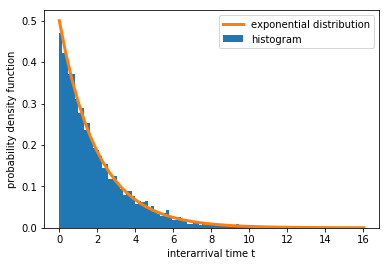

In [9]:
# specify rate
rate = 0.5

# compute a list of pseudo-random numbers from an exponential distribution
x = [random.expovariate(rate) for n in range(0, 10000)]

# plot histogram
plt.hist(x, bins=int(np.sqrt(len(x))), density=True)

# compare to theoretical distribution
t = np.linspace(0, max(x))
plt.plot(t, rate*np.exp(-rate*t), lw=3)
plt.legend(['exponential distribution', 'histogram'])
plt.xlabel('interarrival time t')
plt.ylabel('probability density function')

## Modeling patient arrivals as a Poisson process

### Version 1. Basic simulation

The following cell is a first attempt at a simulation of the patient arrival process. The python generator assigns a patient ID to every new arrival and reports the arrival time.

In [10]:
env = simpy.Environment()

# define a python generator describing the arrival of a new patient
def patient_arrival(env, rate):
  n = 0
  while True:
    yield env.timeout(random.expovariate(rate))
    n = n + 1
    print('Patient', n, 'arrived at', env.now, 'minutes')

# perform a simulation with simpy
env.process(patient_arrival(env, 0.5))
env.run(until=30)

Patient 1 arrived at 1.6054742413576122 minutes
Patient 2 arrived at 2.9862975304596584 minutes
Patient 3 arrived at 6.226685767685777 minutes
Patient 4 arrived at 8.886436229333643 minutes
Patient 5 arrived at 9.105078716440664 minutes
Patient 6 arrived at 10.907985660102916 minutes
Patient 7 arrived at 12.38868161237205 minutes
Patient 8 arrived at 13.583531753095926 minutes
Patient 9 arrived at 16.920435092650337 minutes
Patient 10 arrived at 18.681054931254344 minutes
Patient 11 arrived at 19.79653435459627 minutes
Patient 12 arrived at 24.339149139274646 minutes
Patient 13 arrived at 28.161555082144186 minutes


### Version 2. Adding an event log

A characteristic feature of event-based simulation is the logging of relevant events. Here we use a list to record events as the occur. The record for each event consists of a list of data comprising the patient ID, the time of the event, and type of event.

In [11]:
env = simpy.Environment()

log = []

# define a python generator describing the arrival of a new patient
def patient_arrival(env, rate):
  n = 0
  while True:
    yield env.timeout(random.expovariate(rate))
    n = n + 1
    log.append([n, env.now, 'Arrival'])

# perform a simulation with simpy
env.process(patient_arrival(env, 0.5))
env.run(until=30)

log

[[1, 0.08255875642546838, 'Arrival'],
 [2, 2.154020951510568, 'Arrival'],
 [3, 3.690213096751676, 'Arrival'],
 [4, 3.7292525534379526, 'Arrival'],
 [5, 5.5288177111371555, 'Arrival'],
 [6, 5.964165672571363, 'Arrival'],
 [7, 6.017082273205615, 'Arrival'],
 [8, 11.11180870530135, 'Arrival'],
 [9, 12.79936039051638, 'Arrival'],
 [10, 13.92130464011105, 'Arrival'],
 [11, 15.156231476563278, 'Arrival'],
 [12, 17.149943407249417, 'Arrival'],
 [13, 20.156346210823116, 'Arrival'],
 [14, 25.13846969588947, 'Arrival'],
 [15, 26.988843043672063, 'Arrival'],
 [16, 28.28680275211266, 'Arrival'],
 [17, 28.65926687881398, 'Arrival'],
 [18, 29.299928937955222, 'Arrival']]

### Version 3. Converting the log to a Pandas DataFrame

The next version of our simulation uses the Pandas library to create relevant analytics.

In [12]:
env = simpy.Environment()

log = []

# define a python generator describing the arrival of a new patient
def patient_arrival(env, rate):
  n = 0
  while True:
    yield env.timeout(random.expovariate(rate))
    n = n + 1
    log.append([n, env.now, 'Arrival'])

# perform a simulation with simpy
env.process(patient_arrival(env, 0.5))
env.run(until=30)

# converting the log to a Pandas DataFrame
df = pd.DataFrame(log, columns=['Patient ID', 'Time', 'Event']).set_index('Patient ID')
df

,Time,Event
Patient ID,,
1,0.147039,Arrival
2,0.373035,Arrival
3,1.462077,Arrival
4,3.231856,Arrival
5,3.288754,Arrival
6,4.702892,Arrival
7,11.170035,Arrival
8,18.117774,Arrival
9,18.810539,Arrival


### Version 4. Plotting the DataFrame

Now that we have an analytical tool to summarize the event log, let's use the tool to perform longer simulationsn and show the result graphically.

Text(0, 0.5, 'Arrival Time')

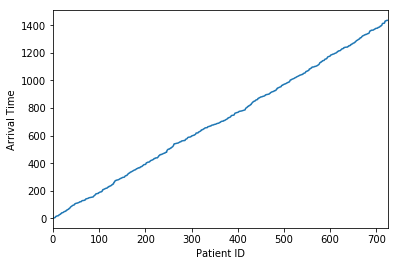

In [13]:
env = simpy.Environment()

log = []

# define a python generator describing the arrival of a new patient
def patient_arrival(env, rate):
  n = 0
  while True:
    yield env.timeout(random.expovariate(rate))
    n = n + 1
    log.append([n, env.now, 'Arrival'])

# perform a simulation with simpy
env.process(patient_arrival(env, 0.5))
env.run(until=1440)

# converting the log to a Pandas DataFrame and plotting the results
df = pd.DataFrame(log, columns=['Patient ID', 'Time', 'Event']).set_index('Patient ID')
ax = df['Time'].plot()
ax.set_ylabel('Arrival Time')

## Version 5. Modeling the emergency room queue and service providers

The next step in this simulation is to model the emergency room queue and hospital service providers. For the emergency room queue we use the [simpy.Stores](https://simpy.readthedocs.io/en/latest/topical_guides/resources.html#stores) object. A Stores object has a `.put()` method the adds a Python object to the queue, and `.get()` method to remove Python objects from the queue. The queue operates in FIFO mode (first-in, first-out) and, by default, with infinite capacity.

We model the actual service as taking a fixed period.

Event,Arrival,Service Finished,Service Start
Patient ID,,,
1,1.663953,11.663953,1.663953
2,4.349066,21.663953,11.663953
3,5.723800,31.663953,21.663953
4,14.943547,41.663953,31.663953
5,15.823235,51.663953,41.663953


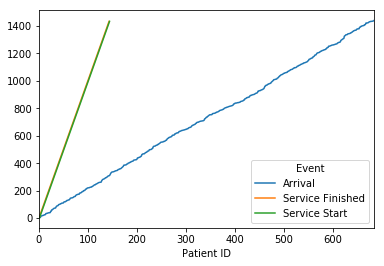

In [18]:
env = simpy.Environment()
emergency_room_queue = simpy.Store(env)

log = []

# define a python generator describing the arrival of a new patient
def patient_arrival(env, rate):
  n = 0
  while True:
    yield env.timeout(random.expovariate(rate))
    n = n + 1
    yield emergency_room_queue.put(n)
    log.append([n, env.now, 'Arrival'])
    
def patient_service(env, tservice):
  while True:
    n = yield emergency_room_queue.get()
    log.append([n, env.now, 'Service Start'])
    yield env.timeout(tservice)
    log.append([n, env.now, 'Service Finished'])

# perform a simulation with simpy
env.process(patient_arrival(env, 0.5))
env.process(patient_service(env, 10))
env.run(until=1440)

# converting the log to a Pandas DataFrame and plotting the results
df = pd.DataFrame(log, columns=['Patient ID', 'Time', 'Event']).set_index('Patient ID')
df = df.pivot(columns='Event', values='Time')
display(df.head())
df.plot()

## Version 6. How many service providers are required?

From the plot above, it is clear that one service provider who takes ten minutes to treat each patient cannot keep up when patients are arriving, on average, every two minutes. We need more service providers. Let's add six and see what happens.

Event,Arrival,Service Finished,Service Start
Patient ID,,,
1,0.926981,10.926981,0.926981
2,2.469486,12.469486,2.469486
3,7.713509,17.713509,7.713509
4,10.039330,20.039330,10.039330
5,10.303165,20.303165,10.303165


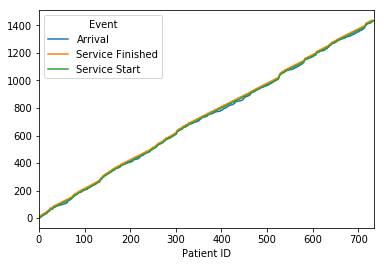

In [44]:
env = simpy.Environment()
emergency_room_queue = simpy.Store(env)

log = []

# define a python generator describing the arrival of a new patient
def patient_arrival(env, rate):
  n = 0
  while True:
    yield env.timeout(random.expovariate(rate))
    n = n + 1
    yield emergency_room_queue.put(n)
    log.append([n, env.now, 'Arrival'])
    
def patient_service(env, tservice):
  while True:
    n = yield emergency_room_queue.get()
    log.append([n, env.now, 'Service Start'])
    yield env.timeout(tservice)
    log.append([n, env.now, 'Service Finished'])

# perform a simulation with simpy
env.process(patient_arrival(env, 0.5))

env.process(patient_service(env, 10))
env.process(patient_service(env, 10))
env.process(patient_service(env, 10))
env.process(patient_service(env, 10))
env.process(patient_service(env, 10))
env.process(patient_service(env, 10))

env.run(until=1440)

# converting the log to a Pandas DataFrame and plotting the results
df = pd.DataFrame(log, columns=['Patient ID', 'Time', 'Event']).set_index('Patient ID')
df = df.pivot(columns='Event', values='Time')
display(df.head())
df.plot()

### Calculating and plotting wait times

With six service providers we now see that patient queue doen't grow indefinitely. Let's look at this in a little more detail by taking a look at how long patients wait for before receiving service.

In [45]:
display(df.head())

Event,Arrival,Service Finished,Service Start
Patient ID,,,
1,0.926981,10.926981,0.926981
2,2.469486,12.469486,2.469486
3,7.713509,17.713509,7.713509
4,10.039330,20.039330,10.039330
5,10.303165,20.303165,10.303165


Text(0.5, 1.0, 'Average Waiting Time = 4.192847877217444 minutes')

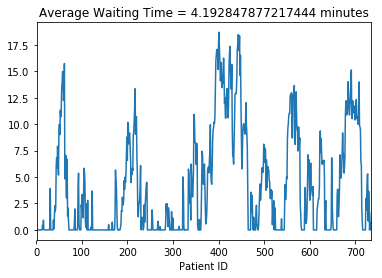

In [46]:
df['Wait Time'] = df['Service Start'] - df['Arrival']
ax = df['Wait Time'].plot()
plt.title('Average Waiting Time = ' + str(df['Wait Time'].mean()) + ' minutes')

### Histogram of wait times

A histogram of wait times provides important insights into the quality of the services being provided by the hospital.

Text(0, 0.5, 'Count')

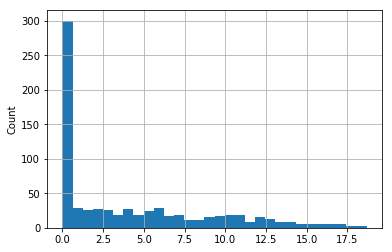

In [47]:
ax = df['Wait Time'].hist(bins=30)
ax.set_ylabel('Count')

## Exercise: Further model development

Copy and paste Version 6 of the model into following code cell.  Then modify the model to incorporate the following features. Insert additional code cells as needed to complete this exercise.

a. The model developed above assumes all emergency room services take the same amount of time. Obviously this is a poor assumption. Change the model so that the (i) the service time is uniformly random number between 5 and 15 minutes, and (ii) after the service to the patient is finished, there is an additional timeout of 5 minutes to allow for medical record keeping and transition to the next patient.

b. Change the data logging so that each time a patient is added or removed from the queue both the time and the length of the resulting queue are logged. You will want to use the Python expression `len(emergency_room_queue.items)` to determine the number of items in the queue.

c. Determine the minimum number of service providers needed to keep the length of the queue finite. Given that number of service providers, determine the average wait time before a patient receives service, and the average length of the emergency room queue. Plot time histories and histograms for both performance indicators.

d. Using the data from (c.), determine if Little's law is satisfied for this simulation.

<!--NAVIGATION-->
< [Queuing Systems](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/02.02-Queuing-Systems.ipynb) | [Contents](toc.ipynb) | [Model Development in SimPy](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/02.04-Discrete-Event-Simulation-of-a-Batch-Process.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455/blob/master/notebooks/02.03-Emergency_Room_Simulation.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE40455/master/notebooks/02.03-Emergency_Room_Simulation.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>